In [1]:
from config import setup, import_and_display_fnc

setup()

# Fault-surface intersection and infinite free surfaces.

**This is a very rough draft**

In the last section, we constructed a method for solving for surface displacement on a free surface given antiplane slip on a fault beneath the free surface. However, the fault was not allowed to intersect the surface of the Earth. In fact, as we will demonstrate here, if the fault had intersected the surface, the surface displacement solution would have been very wrong! In this section, we will fix this problem!

In addition, the last section compared against an analytical solution that assumes an infinite free surface. Unfortunately, we weren't able to match the analytical solution exactly because it's hard to approximate an infinite free surface. It would be easy to stop there and make a compelling argument that the numerical method is working just fine since the error was quite low away from the tips of the free surface. But that didn't leave me satisfied. I want to fit the arctan solution as exactly as possible!

So, our goals in this section are to:
1. Model a fault that intersects the surface of the Earth.
2. Model an infinite free surface to the best of our ability.

Both of these goals will lead to more general methods that are useful for a wide range of problems. In particular, modeling an infinite free surface will force us to implement some **adaptive meshing** tools that will be very useful for other problems where the spatial scale of interest varies widely through the domain.

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from common import (
    gauss_rule,
    qbx_matrix,
    symbolic_eval,
    build_interp_matrix,
    build_interpolator,
    qbx_setup,
    double_layer_matrix,
)

## Panels

The key to solving both these problem will be to separate the surface into many smaller components that we will call "panels". Up until now, every surface we've dealt with has been parameterized with a single curve and then discretized using a single quadrature rule, either Gaussian or trapezoidal. Why does separating this single surface into subcomponents help?
1. A Gaussian quadrature rule implicitly assumes that the function being integrated is smooth. However, at a fault-surface intersection, the surface displacement will actually be discontinuous! 
2. The resolution needed near the fault will be high. The resolution needed 100 fault lengths away from the fault trace is very low. So, we will need to have higher point density in some places than others. We will achieve this by refining some panels to be much smaller than others. 

[draft note] Explain the code below more.

In [3]:
import_and_display_fnc('common', 'PanelSurface')
import_and_display_fnc('common', 'panelize_symbolic_surface')
import_and_display_fnc('common', 'refine_panels')
import_and_display_fnc('common', 'stage1_refine')
import_and_display_fnc('common', 'qbx_panel_setup')
import_and_display_fnc('common', 'stage2_refine')

@dataclass()
class PanelSurface:
    # Hierarchy: Boundary -> Element -> Panel -> Point
    # A boundary consists of several segments.
    # An element consists of a single parametrized curve that might be composed of several panels.
    # A panel consists of a quadrature rule defined over a subset of a parametrized curve.

    qx: np.ndarray
    qw: np.ndarray

    quad_pts: np.ndarray
    quad_wts: np.ndarray
    pts: np.ndarray
    normals: np.ndarray
    jacobians: np.ndarray
    radius: np.ndarray
    panel_bounds: np.ndarray
    panel_start_idxs: np.ndarray
    panel_sizes: np.ndarray
    panel_centers: np.ndarray
    panel_length: np.ndarray

    def __init__(
        self, qx, qw, quad_pts, quad_wts, pts, normals, jacobians, radius, panel_bounds
    ):
        self.qx = qx
        self.qw = qw
        self.quad_pts = quad_pts
        self.quad_wts = quad_wts
        self.pts = pts
        self.normals = normals
        self.jacobians = jacobians
        self.radius = radius
        self.panel_bounds = panel_bounds

        panel_parameter_width = self.panel_bounds[:, 1] - self.panel_bounds[:, 0]
        self.panel_sizes = np.full(self.panel_bounds.shape[0], self.panel_order)
        self.panel_start_idxs = np.cumsum(self.panel_sizes) - self.panel_order
        self.panel_centers = (1.0 / panel_parameter_width[:, None]) * np.sum(
            (self.quad_wts[:, None] * self.pts).reshape((-1, self.panel_order, 2)),
            axis=1,
        )
        self.panel_length = np.sum(
            (self.quad_wts * self.jacobians).reshape((-1, self.panel_order)), axis=1
        )

    @property
    def panel_order(self):
        return self.qx.shape[0]

    @property
    def n_pts(self):
        return self.pts.shape[0]

    @property
    def n_panels(self):
        return self.panel_bounds.shape[0]

def panelize_symbolic_surface(t, x, y, panel_bounds, qx, qw):
    """
    Construct a surface out of a symbolic parametrized curve splitting the curve parameter at
    `panel_bounds` into subcomponent. `panel_bounds` is expected to be a list of ranges of
    the parameter `t` that spans from [-1, 1]. For example:
    `panel_bounds = [(-1,-0.5),(-0.5,0),(0,1)]` would split the surface into three panels extending from
    1. t = -1 to t = -0.5
    2. t=-0.5 to t=0
    3. t=0 to t=1.
    """
    dxdt = sp.diff(x, t)
    dydt = sp.diff(y, t)

    jacobian = sp.sqrt(dxdt ** 2 + dydt ** 2)

    dx2dt2 = sp.diff(dxdt, t)
    dy2dt2 = sp.diff(dydt, t)
    # A small factor is added to the radius of curvature denominator
    # so that we don't divide by zero when a surface is flat.
    radius = jacobian ** 3 / (dxdt * dy2dt2 - dydt * dx2dt2 + 1e-16)

    nx = -dydt / jacobian
    ny = dxdt / jacobian

    quad_pts = []

    panel_parameter_width = panel_bounds[:, 1] - panel_bounds[:, 0]

    quad_pts = (
        panel_bounds[:, 0, None]
        + panel_parameter_width[:, None] * (qx[None, :] + 1) * 0.5
    ).flatten()
    quad_wts = (panel_parameter_width[:, None] * qw[None, :] * 0.5).flatten()
    surf_vals = [
        symbolic_eval(t, quad_pts, v) for v in [x, y, nx, ny, jacobian, radius]
    ]

    pts = np.hstack((surf_vals[0][:, None], surf_vals[1][:, None]))
    normals = np.hstack((surf_vals[2][:, None], surf_vals[3][:, None]))
    jacobians = surf_vals[4]
    radius_of_curvature = surf_vals[5]

    return PanelSurface(
        qx,
        qw,
        quad_pts,
        quad_wts,
        pts,
        normals,
        jacobians,
        radius_of_curvature,
        panel_bounds,
    )

def refine_panels(panels, which):
    new_panels = []
    for i in range(panels.shape[0]):
        if which[i]:
            left, right = panels[i]
            midpt = 0.5 * (left + right)
            new_panels.append([left, midpt])
            new_panels.append([midpt, right])
        else:
            new_panels.append(panels[i])
    new_panels = np.array(new_panels)
    return new_panels

def stage1_refine(
    sym_surf,
    quad_rule,
    other_surfaces=[],
    initial_panels=np.array([[-1, 1]]),
    max_radius_ratio=0.25,
    control_points=None,
    max_iter=30,
):
    cur_panels = initial_panels.copy()

    other_surf_trees = []
    for other_surf in other_surfaces:
        other_surf_trees.append(scipy.spatial.KDTree(other_surf.panel_centers))

    if control_points is not None:
        control_points = np.asarray(control_points)
        control_tree = scipy.spatial.KDTree(control_points[:, :2])

    for i in range(max_iter):
        # Step 0) Create a PanelSurface from the current set of panels.
        # note that this step would need to look different if the surface were
        # defined from an input segment geometry rather than from a symbolic
        # curve specification.
        cur_surf = panelize_symbolic_surface(
            sym_surf[0], sym_surf[1], sym_surf[2], cur_panels, *quad_rule
        )

        # Step 1) Refine based on radius of curvature
        panel_radius = np.min(
            cur_surf.radius.reshape((-1, quad_rule[0].shape[0])), axis=1
        )
        refine_from_radius = cur_surf.panel_length > max_radius_ratio * panel_radius

        # Step 2) Refine based on a nearby user-specified control points.
        if control_points is not None:
            nearby_controls = control_tree.query(cur_surf.panel_centers)
            nearest_control_pt = control_points[nearby_controls[1], :]
            refine_from_control = (
                nearby_controls[0]
                < 0.5 * cur_surf.panel_length + nearest_control_pt[:, 2]
            ) & (cur_surf.panel_length > nearest_control_pt[:, 3])
        else:
            refine_from_control = np.zeros(cur_surf.n_panels, dtype=bool)

        # Step 3) Refine based on the length scale imposed by other nearby surfaces
        refine_from_nearby = np.zeros(cur_surf.n_panels, dtype=bool)
        for j, other_surf in enumerate(other_surfaces):
            nearby_surf_panels = other_surf_trees[j].query(cur_surf.panel_centers)
            nearby_dist = nearby_surf_panels[0]
            nearby_panel_length = other_surf.panel_length[nearby_surf_panels[1]]
            refine_from_nearby |= (
                0.5 * nearby_panel_length + nearby_dist < cur_surf.panel_length
            )

        # Step 4) Ensure that panel length scale doesn't change too rapidly. This
        # essentially imposes that a panel will be no more than twice the length
        # of any adjacent panel.
        # TODO: I'm unsure if this is necessary!
        if cur_surf.n_panels > 1:
            panel_tree = scipy.spatial.KDTree(cur_surf.panel_centers)
            # Use k=2 because the closest panel will be the query panel itself.
            nearby_panels = panel_tree.query(cur_surf.panel_centers, k=2)
            nearby_dist = nearby_panels[0][:, 1]
            nearby_idx = nearby_panels[1][:, 1]
            nearby_panel_length = cur_surf.panel_length[nearby_idx]
            # The criterion will be: self_panel_length + sep < 0.5 * panel_length
            # but since sep = self_dist - 0.5 * panel_length - 0.5 * self_panel_length
            # we can simplify the criterion to:
            # Since the self distance metric is symmetric, we only need to check
            # if the panel is too large.
            fudge_factor = 0.01
            refine_from_self = (
                0.5 * nearby_panel_length + nearby_dist
                < (1 - fudge_factor) * cur_surf.panel_length
            )
        else:
            refine_from_self = np.zeros(cur_surf.n_panels, dtype=bool)

        refine = (
            refine_from_control
            | refine_from_radius
            | refine_from_self
            | refine_from_nearby
        )
        new_panels = refine_panels(cur_panels, refine)

        # TODO: add a callback for debugging? or some logging?
        #     plt.plot(s.pts[s.panel_start_idxs,0], s.pts[s.panel_start_idxs,1], 'k-*')
        #     plt.show()
        #     p

def qbx_panel_setup(source, other_surfaces=[], mult=0.5, direction=0, p=5):
    other_surf_trees = []
    for other_surf in other_surfaces:
        other_surf_trees.append(scipy.spatial.KDTree(other_surf.pts))

    
    r = mult * np.repeat(source.panel_length, source.panel_order)
    if direction == 0:
        offset = np.concatenate((r, -r))
    else:
        offset = direction * r
    
    
    max_iter = 10
    for i in range(max_iter):
        centers = source.pts + offset[:, None] * source.normals
        #break
        which_violations = np.zeros(centers.shape[0], dtype=bool)
        for t in other_surf_trees:
            nearby_surf_panels = t.query(centers)
            which_violations |= (nearby_surf_panels[0] < np.abs(offset))
        if not which_violations.any():
            break
        offset[which_violations] /= 2

    return QBXExpansions(centers, np.abs(offset), p)

def stage2_refine(surf, expansions, max_iter=30, distance_limit=0.49, kappa=3):
    stage2_panels = np.array(
        [np.arange(surf.n_panels), -np.ones(surf.n_panels), np.ones(surf.n_panels)]
    ).T
    panel_parameter_width = surf.panel_bounds[:, 1] - surf.panel_bounds[:, 0]
    expansion_tree = scipy.spatial.KDTree(expansions.pts)

    for i in range(max_iter):
        stage2_surf, _ = build_stage2_panel_surf(surf, stage2_panels, surf.qx, surf.qw)

        min_panel_expansion_dist = np.min(
            expansion_tree.query(stage2_surf.pts)[0].reshape((-1, surf.panel_order)),
            axis=1,
        )
        refine = min_panel_expansion_dist < distance_limit * stage2_surf.panel_length

        new_quad_panel_domains = refine_panels(stage2_panels[:, 1:], refine)
        new_in_panel_idx = np.repeat(stage2_panels[:, 0], refine + 1)
        new_quad_panels = np.hstack((new_in_panel_idx[:, None], new_quad_panel_domains))

        if stage2_panels.shape[0] == new_quad_panels.shape[0]:
            break
        stage2_panels = new_quad_panels

    out_order = surf.panel_order * kappa
    upsampled_gauss = gauss_rule(out_order)
    final_surf, interp_mat = build_stage2_panel_surf(surf, stage2_panels, *upsampled_gauss)
    return final_surf, interp_mat

In [4]:
corner_resolution = 0.5
surf_half_L = 2000

qx, qw = gauss_rule(6)
t = sp.var("t")


control_points = np.array([(0, 0, 2, corner_resolution)])
fault = stage1_refine((t, t * 0, (t + 1) * -0.5), (qx, qw))
flat = stage1_refine(
    (t, -t * surf_half_L, 0 * t), (qx, qw), other_surfaces=[fault], control_points=control_points
)
expansions = qbx_panel_setup(flat, other_surfaces=[fault], direction=1, p=10)
fault_stage2, fault_interp_mat = stage2_refine(fault, expansions)
flat_stage2, flat_interp_mat = stage2_refine(flat, expansions)

done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50


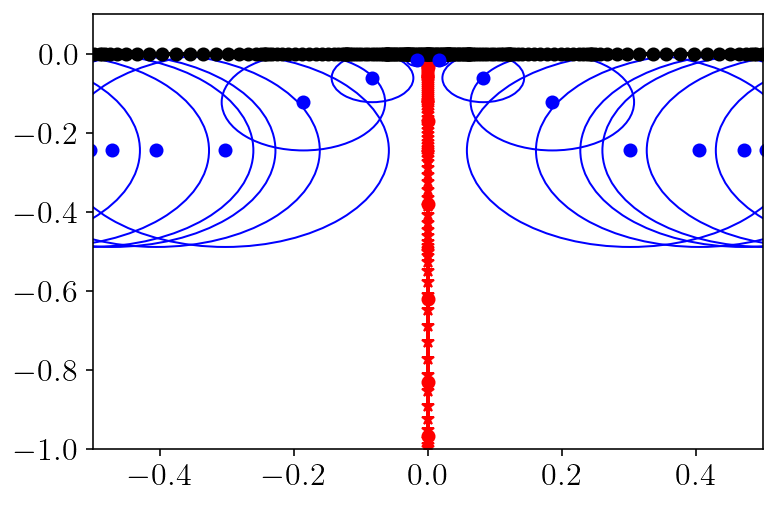

In [5]:
%matplotlib inline
plt.figure()
plt.plot(fault.pts[:,0], fault.pts[:,1], 'r-o')
plt.plot(fault_stage2.pts[:,0], fault_stage2.pts[:,1], 'r*')
plt.plot(flat_stage2.pts[:,0], flat_stage2.pts[:,1], 'k-o')
plt.plot(expansions.pts[:,0], expansions.pts[:,1], 'bo')
for i in range(expansions.N):
    plt.gca().add_patch(plt.Circle(expansions.pts[i], expansions.r[i], color='b', fill=False))
plt.xlim([-0.5,0.5])
plt.ylim([-1, 0.1])
plt.show()

In the figure below, I plot $log_{10}(x)$ against the point index. You can see that the spacing of points is much finer near the fault surface intersection and rapidly increases away from the fault surface intersection.

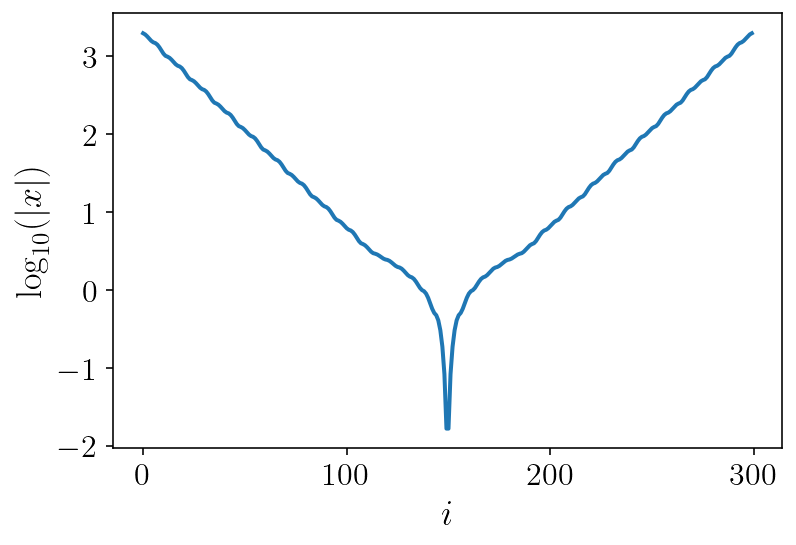

In [6]:
plt.plot(np.log10(np.abs(flat.pts[:,0])))
plt.xlabel(r'$i$')
plt.ylabel(r'$\log_{10}(|x|)$')

plt.show()

In [7]:
print('number of points in the free surface discretization:', flat.n_pts)
print('                        fault        discretization:', fault.n_pts)
print('                        free surface     quadrature:', flat_stage2.n_pts)
print('                        fault            quadrature:', fault_stage2.n_pts)

number of points in the free surface discretization: 300
                        fault        discretization: 6
                        free surface     quadrature: 1404
                        fault            quadrature: 108


In [8]:
%%time
A_raw = qbx_matrix(double_layer_matrix, flat_stage2, flat.pts, expansions)[:, 0, :]

CPU times: user 671 ms, sys: 293 ms, total: 964 ms
Wall time: 964 ms


In [9]:
%%time
A = A_raw.dot(flat_interp_mat.toarray())

CPU times: user 23.9 ms, sys: 3.99 ms, total: 27.9 ms
Wall time: 6.33 ms


In [10]:
B = -qbx_matrix(double_layer_matrix, fault_stage2, flat.pts, expansions)[:, 0, :]

In [11]:
lhs = np.eye(A.shape[0]) + A
rhs = B.dot(np.ones(fault_stage2.n_pts))
surf_disp = np.linalg.solve(lhs, rhs)

# Note that the analytical solution is slightly different than in the buried 
# fault setting because we need to take the limit of an arctan as the 
# denominator of the argument  goes to zero.
s = 1.0
analytical_fnc = lambda x: -np.arctan(-1 / x) / np.pi
analytical = analytical_fnc(flat.pts[:,0])

In the first row of graphs below, I show the solution extending to 10 fault lengths. In the second row, the solution extends to 1000 fault lengths. You can see that the solution matches to about 6 digits in the nearfield and 7-9 digits in the very farfield!

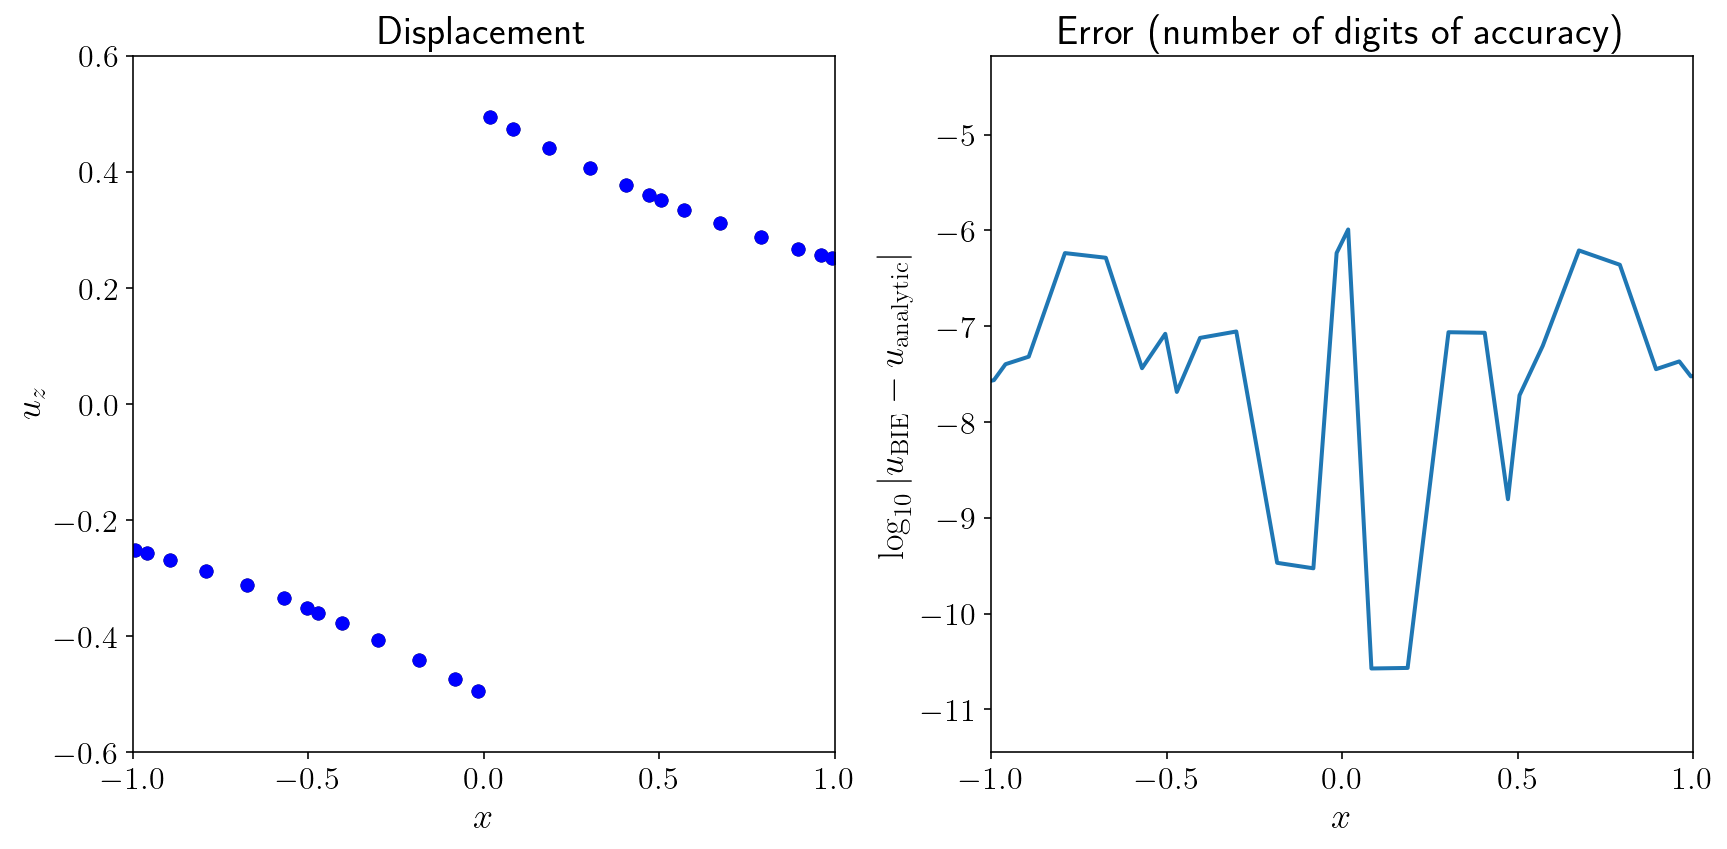

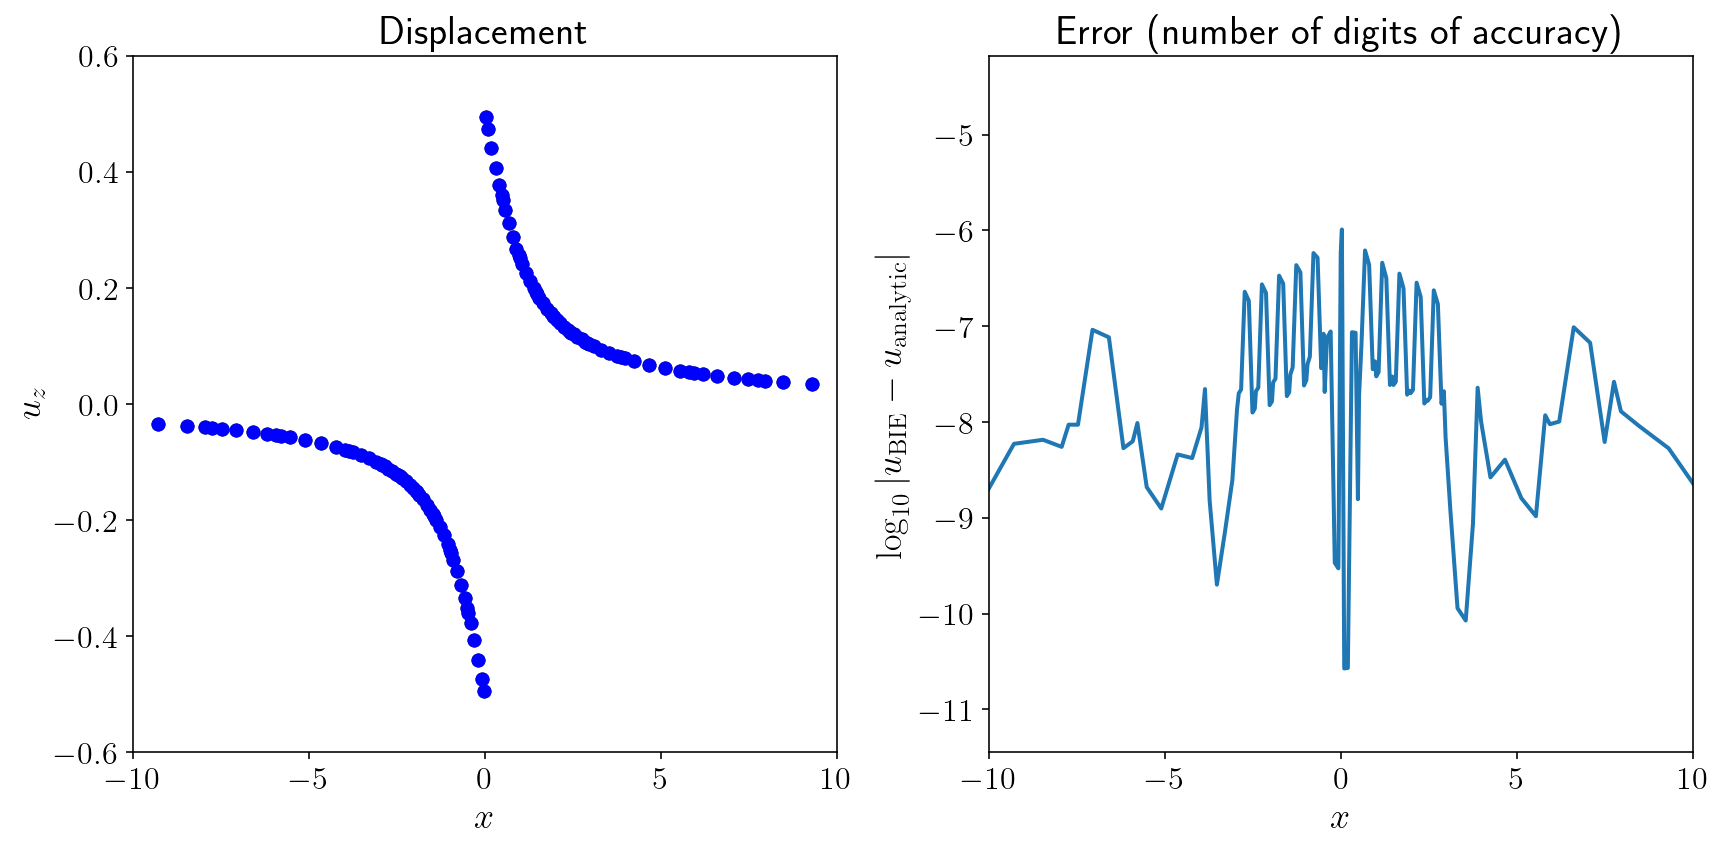

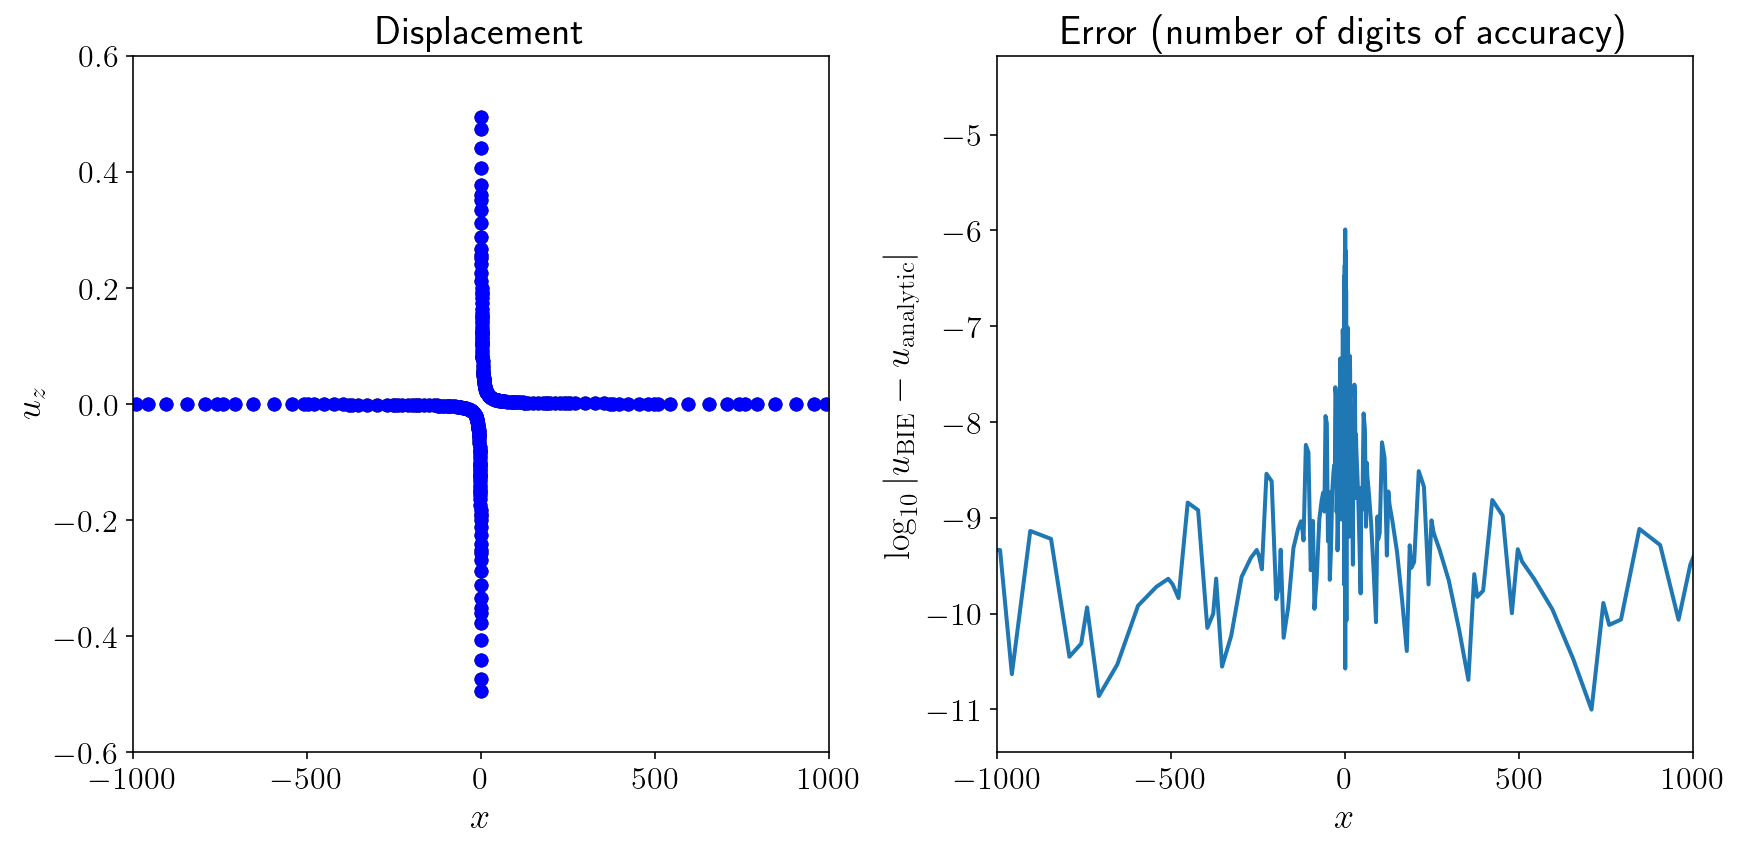

In [12]:
%matplotlib inline
for XV in [1.0, 10.0, 1000.0]:
    # XV = 5 * corner_resolution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(flat.pts[:, 0], surf_disp, "ko")
    plt.plot(flat.pts[:, 0], analytical, "bo")
    plt.xlabel("$x$")
    plt.ylabel("$u_z$")
    plt.title("Displacement")
    plt.xlim([-XV, XV])
    plt.ylim([-0.6, 0.6])

    plt.subplot(1, 2, 2)
    plt.plot(flat.pts[:, 0], np.log10(np.abs(surf_disp - analytical)))
    plt.xlabel("$x$")
    plt.ylabel(r"$\log_{10}|u_{\textrm{BIE}} - u_{\textrm{analytic}}|$")
    plt.title("Error (number of digits of accuracy)")
    plt.tight_layout()
    plt.xlim([-XV, XV])
    plt.show()

remaining parameter list:
- $\kappa$
- qbx order $p$
- qbx distance $r$ (or in the code `mult`), probably just leave this as $L/2$ (where $L$ is the panel length)
- mesh refinement

The two remaining parameters are $\kappa$ and $r$. I've decided on $r=0.5*L_{panel}$, so the only remaining issue is to set $\kappa$ based on the error tolerance $\epsilon$. The relationship will look like $\kappa = f(\epsilon, \textrm{panel shape}, \textrm{kernel})$ because the panel shape and the choice of kernel will also drive the error function. I can look at the Klinteberg paper to get a sense of what the error estimate should look like. Then I can just empirically fit the constants in that error estimate based.

In [209]:
surfs = []
solns = []
qx_ps = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

surf_half_L = 2000

for qx_p in qx_ps:
    qx, qw = gauss_rule(qx_p)
    t = sp.var("t")
    control_points = np.array([(0, 0, 2, corner_resolution)])
    fault = stage1_refine((t, t * 0, (t + 1) * -0.5), (qx, qw))
    flat = stage1_refine(
        (t, -t * surf_half_L, 0 * t), (qx, qw), other_surfaces=[fault], control_points=control_points
    )
    expansions = qbx_panel_setup(flat, other_surfaces=[fault], direction=1, p=15)
    fault_stage2, fault_interp_mat = stage2_refine(fault, expansions)
    flat_stage2, flat_interp_mat = stage2_refine(flat, expansions)
    A_raw = qbx_matrix(double_layer_matrix, flat_stage2, flat.pts, expansions)[:, 0, :]
    A = A_raw.dot(flat_interp_mat.toarray())
    B = -qbx_matrix(double_layer_matrix, fault_stage2, flat.pts, expansions)[:, 0, :]
    lhs = np.eye(A.shape[0]) + A
    rhs = B.dot(np.ones(fault_stage2.n_pts))
    surf_disp = np.linalg.solve(lhs, rhs)
    surfs.append(flat)
    solns.append(surf_disp)

done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50
done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50
done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50
done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50
done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50
done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50
done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50
done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50
done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50
done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50
done after n_iterations=0 with n_panels=1
done after n_iterations=21 with n_panels=50


In [210]:
for i in range(len(qx_ps)):
    remove_end_idx = qx_ps[i] * 2
#     plt.plot(np.log10(np.abs(solns[i] - analytical_fnc(surfs[i].pts[:,0]))))
#     plt.show()
    diff = solns[i][remove_end_idx:-remove_end_idx] - analytical_fnc(surfs[i].pts[remove_end_idx:-remove_end_idx,0])
    l2_err = np.linalg.norm(diff)
    linf_err = np.max(np.abs(diff))
    print(qx_ps[i], l2_err, linf_err)

2 2.770562487891361 2.207101085624286
3 0.3021767708303932 0.1410452246474574
4 0.020879734178085682 0.016318114736611156
5 0.0013431127068156917 0.0006239420502175408
6 8.90149976579911e-05 6.0614169656747485e-05
7 3.0961519912670455e-06 2.439107467111512e-06
8 1.7449564808632917e-07 5.748119263904172e-08
9 4.3764039051675084e-09 3.0025551489565316e-09
10 4.549067261238486e-10 2.593343317869312e-10
11 5.827229941930767e-10 3.615096555442676e-10
12 4.505633201605238e-10 2.7591146034566805e-10
